Hunter Bennett | Glass Lab | Kupffer Strains Project | 4 June 2021

In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib_venn as venn
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

In [3]:
import scipy.stats as stats

# Set working directory

In [4]:
leptinDirectory = '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/Leptin_6hours/'
controlDirectory = '/gpfs/data01/glasslab/home/h1bennet/strains/data/ATAC/control_cohort2/'
workingDirectory = '/home/h1bennet/strains/results/11_Strains_Leptin_6h_ATAC'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


# We will start by using O'young's script to get the IDR peaks for each condition
____
We already made these for the QC notebook!  

The output of peakIDR.R includes many things, the main thing we use are the final .idr peak files for each group


# Run peakIDR.R

    source activate r-ouyangPipe
    
    mkdir ./peakIDR/

    mkdir ./peakQuan/

    mkdir ./peakDiff/

    nohup peakIDR.R ./sampleDef.txt -o ./peakIDR/ > peakIDR.nohup.out
    
    nohup peakQuan.R ./sampleDef.txt -o ./peakQuan/ -g mm10 -a atac \
    -i ./peakIDR/ --homer='-size 200 -pc 0' > peakQuan.nohup.out
    
    nohup peakDiff.R ./sampleDef.txt -o ./peakDiff/ -g mm10 -a atac \
    -q ./peakQuan/allRawTags.txt > peakDiff.nohup.out

# Summary plots

In [5]:
# make folder for figures
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

### Read in annotation files

In [6]:
# import annotation file
df, mat = read_annotated_peaks('./peakQuan/allNormTags.txt')

# shorten columns to make labeling nicer
mat.columns = mat.columns.str.split('/').str[-1]

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

In [9]:
mat_quant.shape

(85322, 20)

Filter low tag peaks

In [8]:
# use group based mat filter - have to set manually
print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
groups=[[0,1,2,3], [4,5,6], [7,8,9,10], [11,12], [13,14,15,16], [17,18,19]]
peaks = []
for group in groups:
    peaks.extend(mat.loc[mat.iloc[:, group].mean(1) > 5, :].index.tolist())
mat = mat.reindex(list(set(peaks)))
mat = mat.dropna(how='all')
mat_quant = mat_quant.reindex(list(set(peaks)))
mat_quant = mat_quant.dropna(how='all')
print(mat.shape[0], 'total peaks')

87899 total peaks
filtering low tag count peaks
85322 total peaks


### Mean variance plot

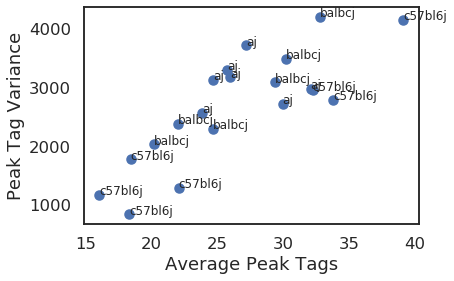

In [11]:
ax = plt.scatter(mat.mean(), mat.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat.mean(),
            mat.var(),
            mat_quant.columns.str.split('_').str[0],
            plt.gca())

plt.savefig('./figures/mean_variance_plot.png',
            bbox_inches='tight')

### Try with quantile normalized data

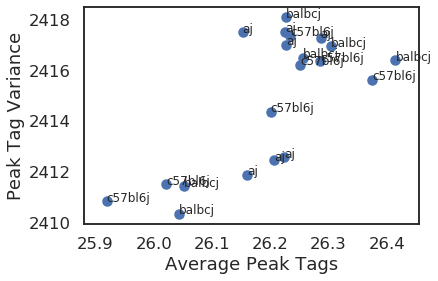

In [12]:
ax = plt.scatter(mat_quant.mean(), mat_quant.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat_quant.mean(),
            mat_quant.var(),
            mat_quant.columns.str.split('_').str[0],
            plt.gca())

plt.savefig('./figures/mean_variance_plot_quantnorm.png',
            bbox_inches='tight')

### Scatter plot

In [13]:
# g = sns.PairGrid(np.log2(mat+1), height=10)
# g.map(plt.scatter);
# plt.savefig('./figures/atac_corr_scatter.png', bbox_inches='tight')

In [14]:
# g = sns.PairGrid(np.log2(mat_quant+1), height=10)
# g.map(plt.scatter);
# plt.savefig('./figures/atac_corr_scatter_quantnorm.png', bbox_inches='tight')

### Correlation heatmap

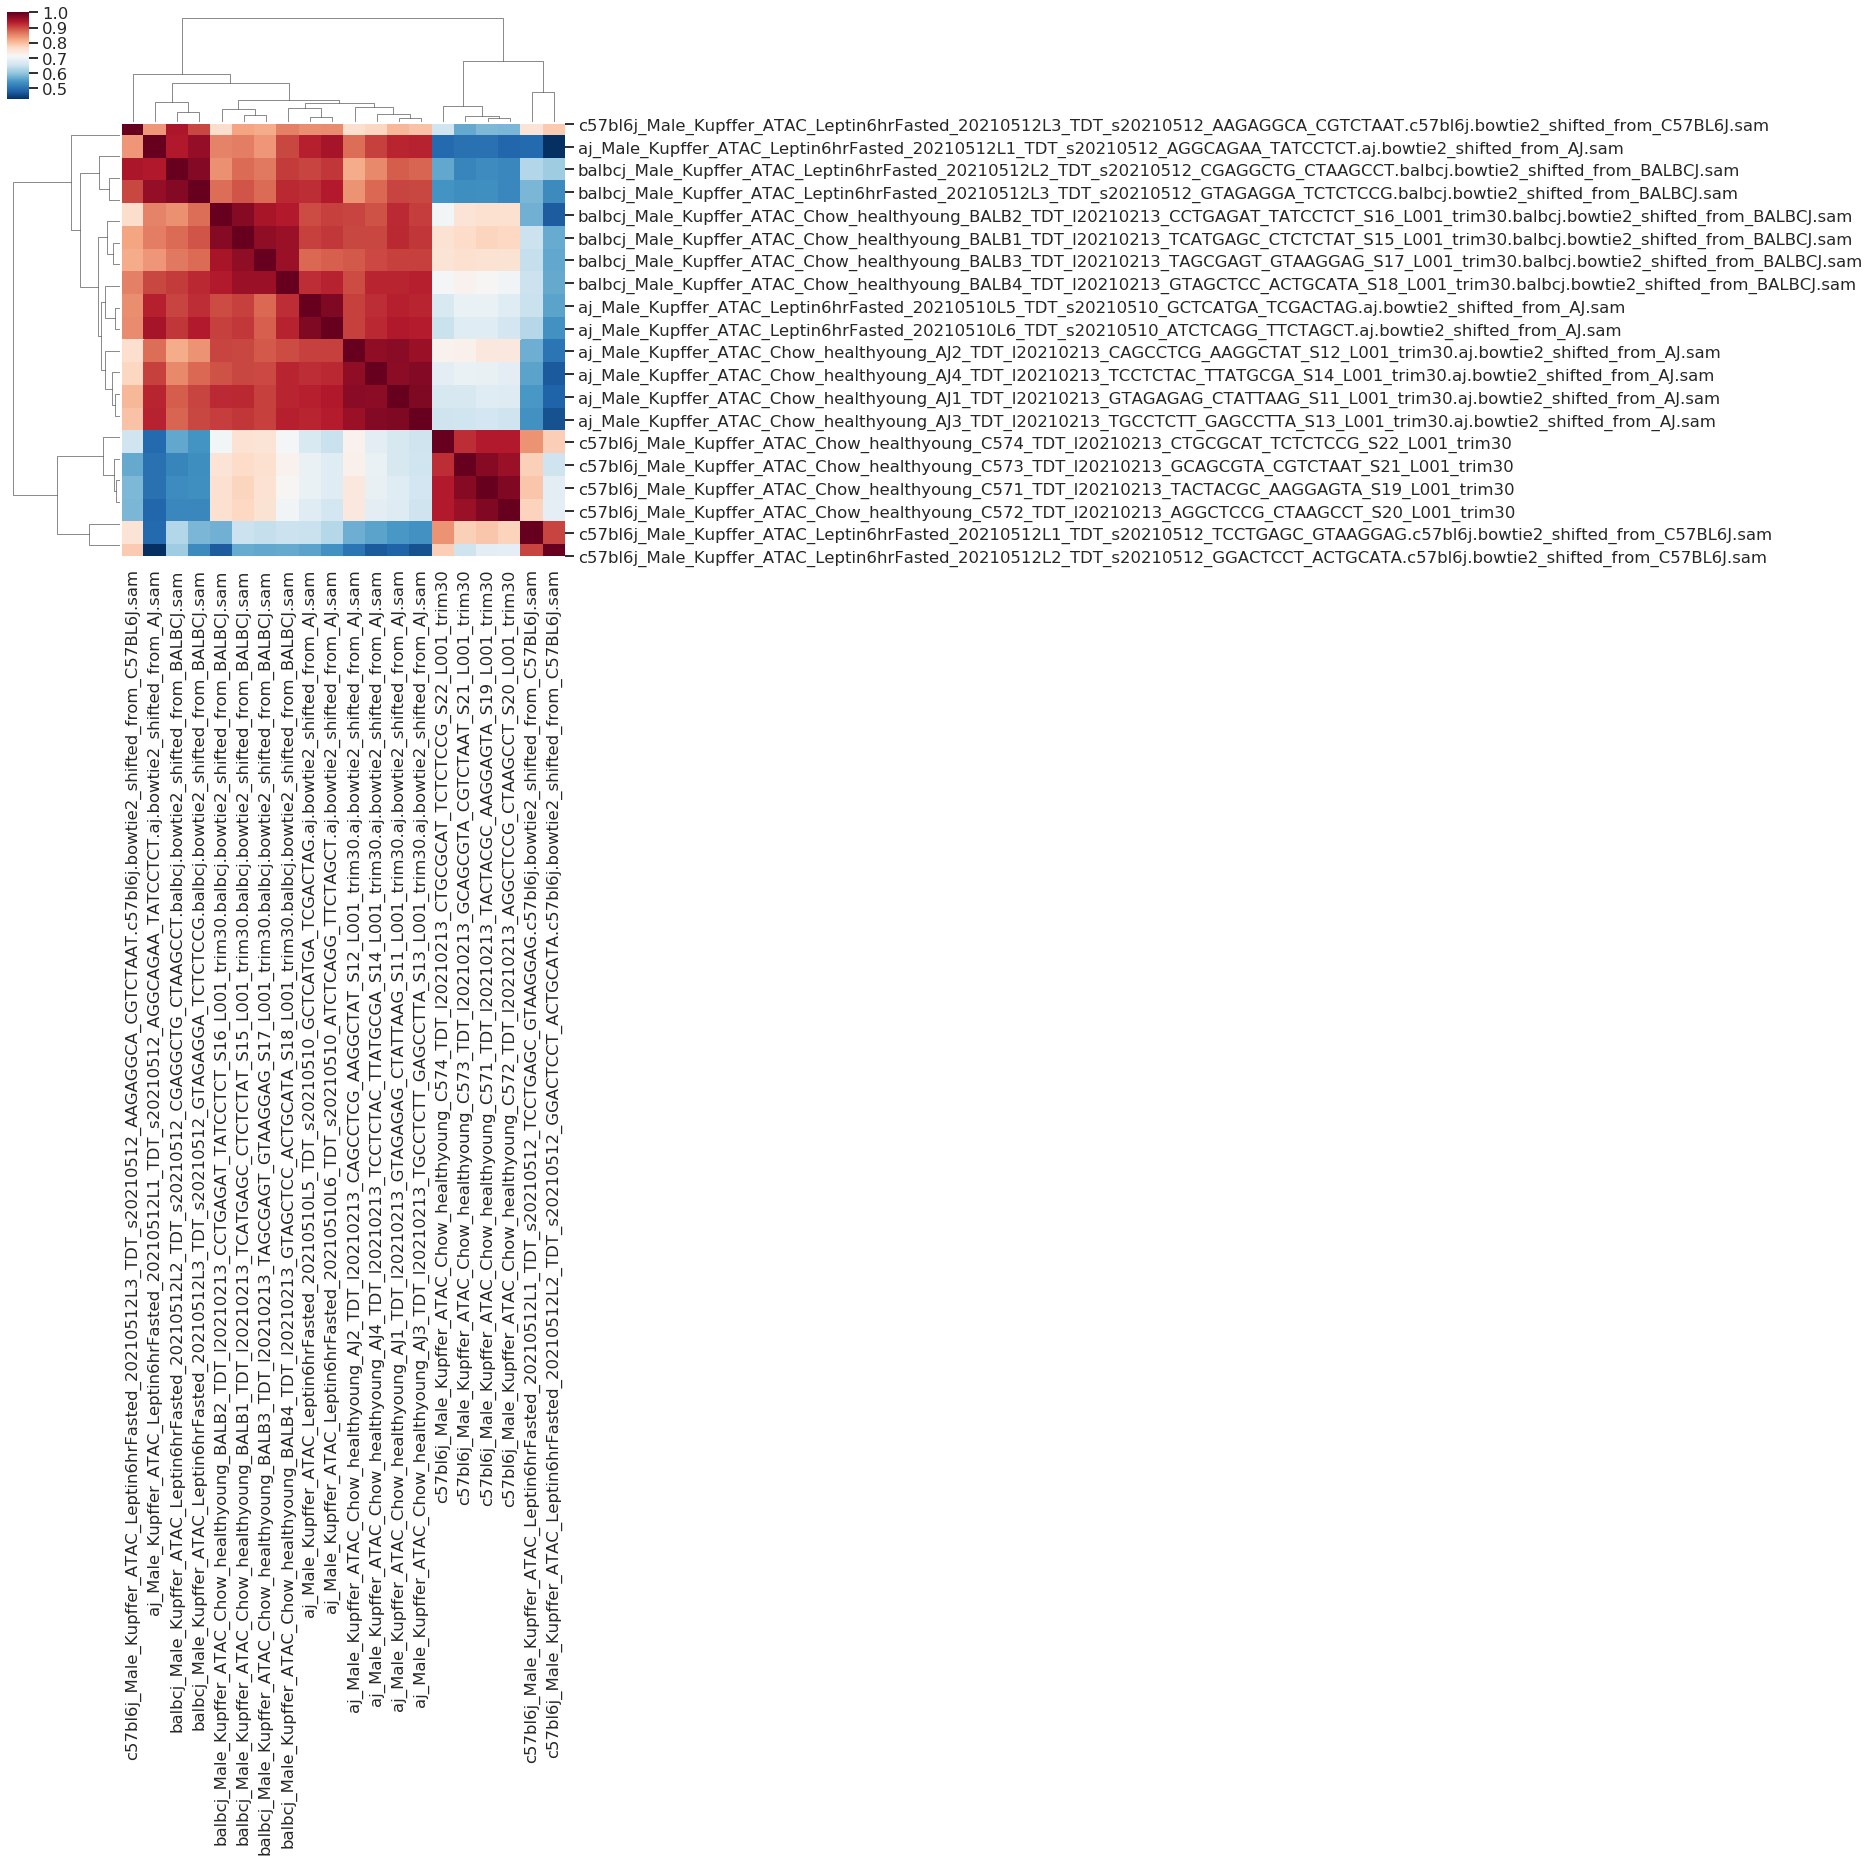

In [15]:
cm = sns.clustermap(mat.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/atac_correlation_heatmap.png', bbox_inches='tight')

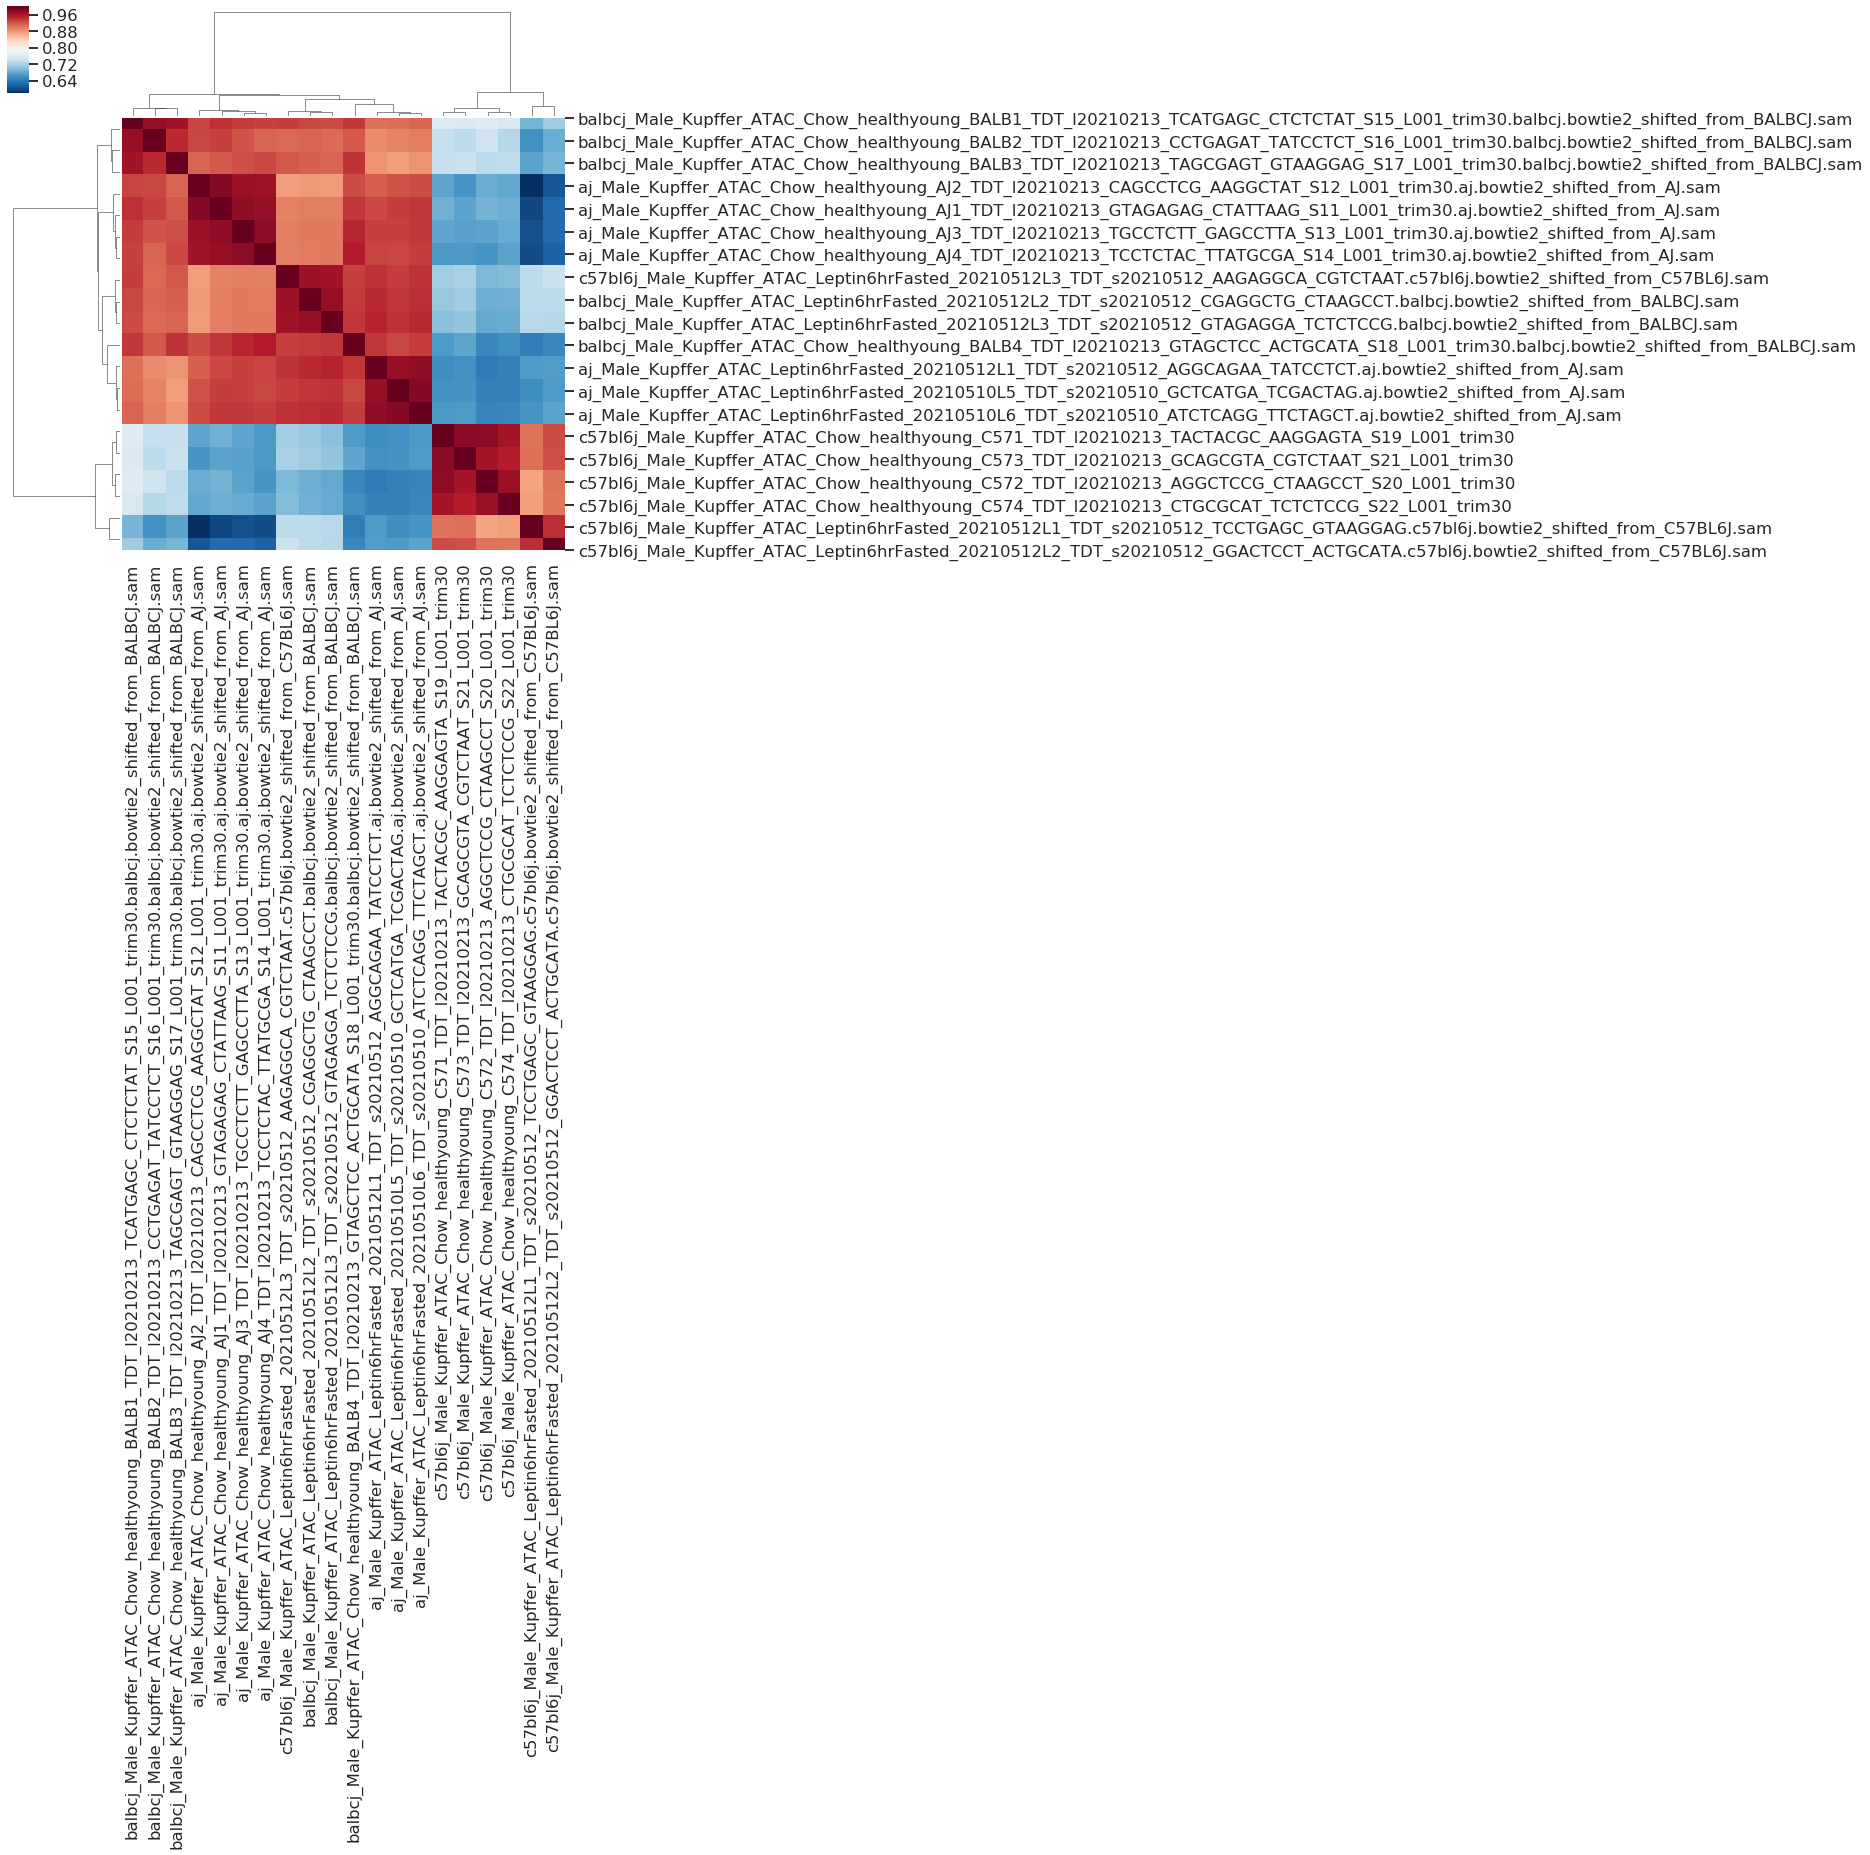

In [16]:
cm = sns.clustermap(mat_quant.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/atac_correlation_heatmap_quantnorm.png', bbox_inches='tight')

In [17]:
mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

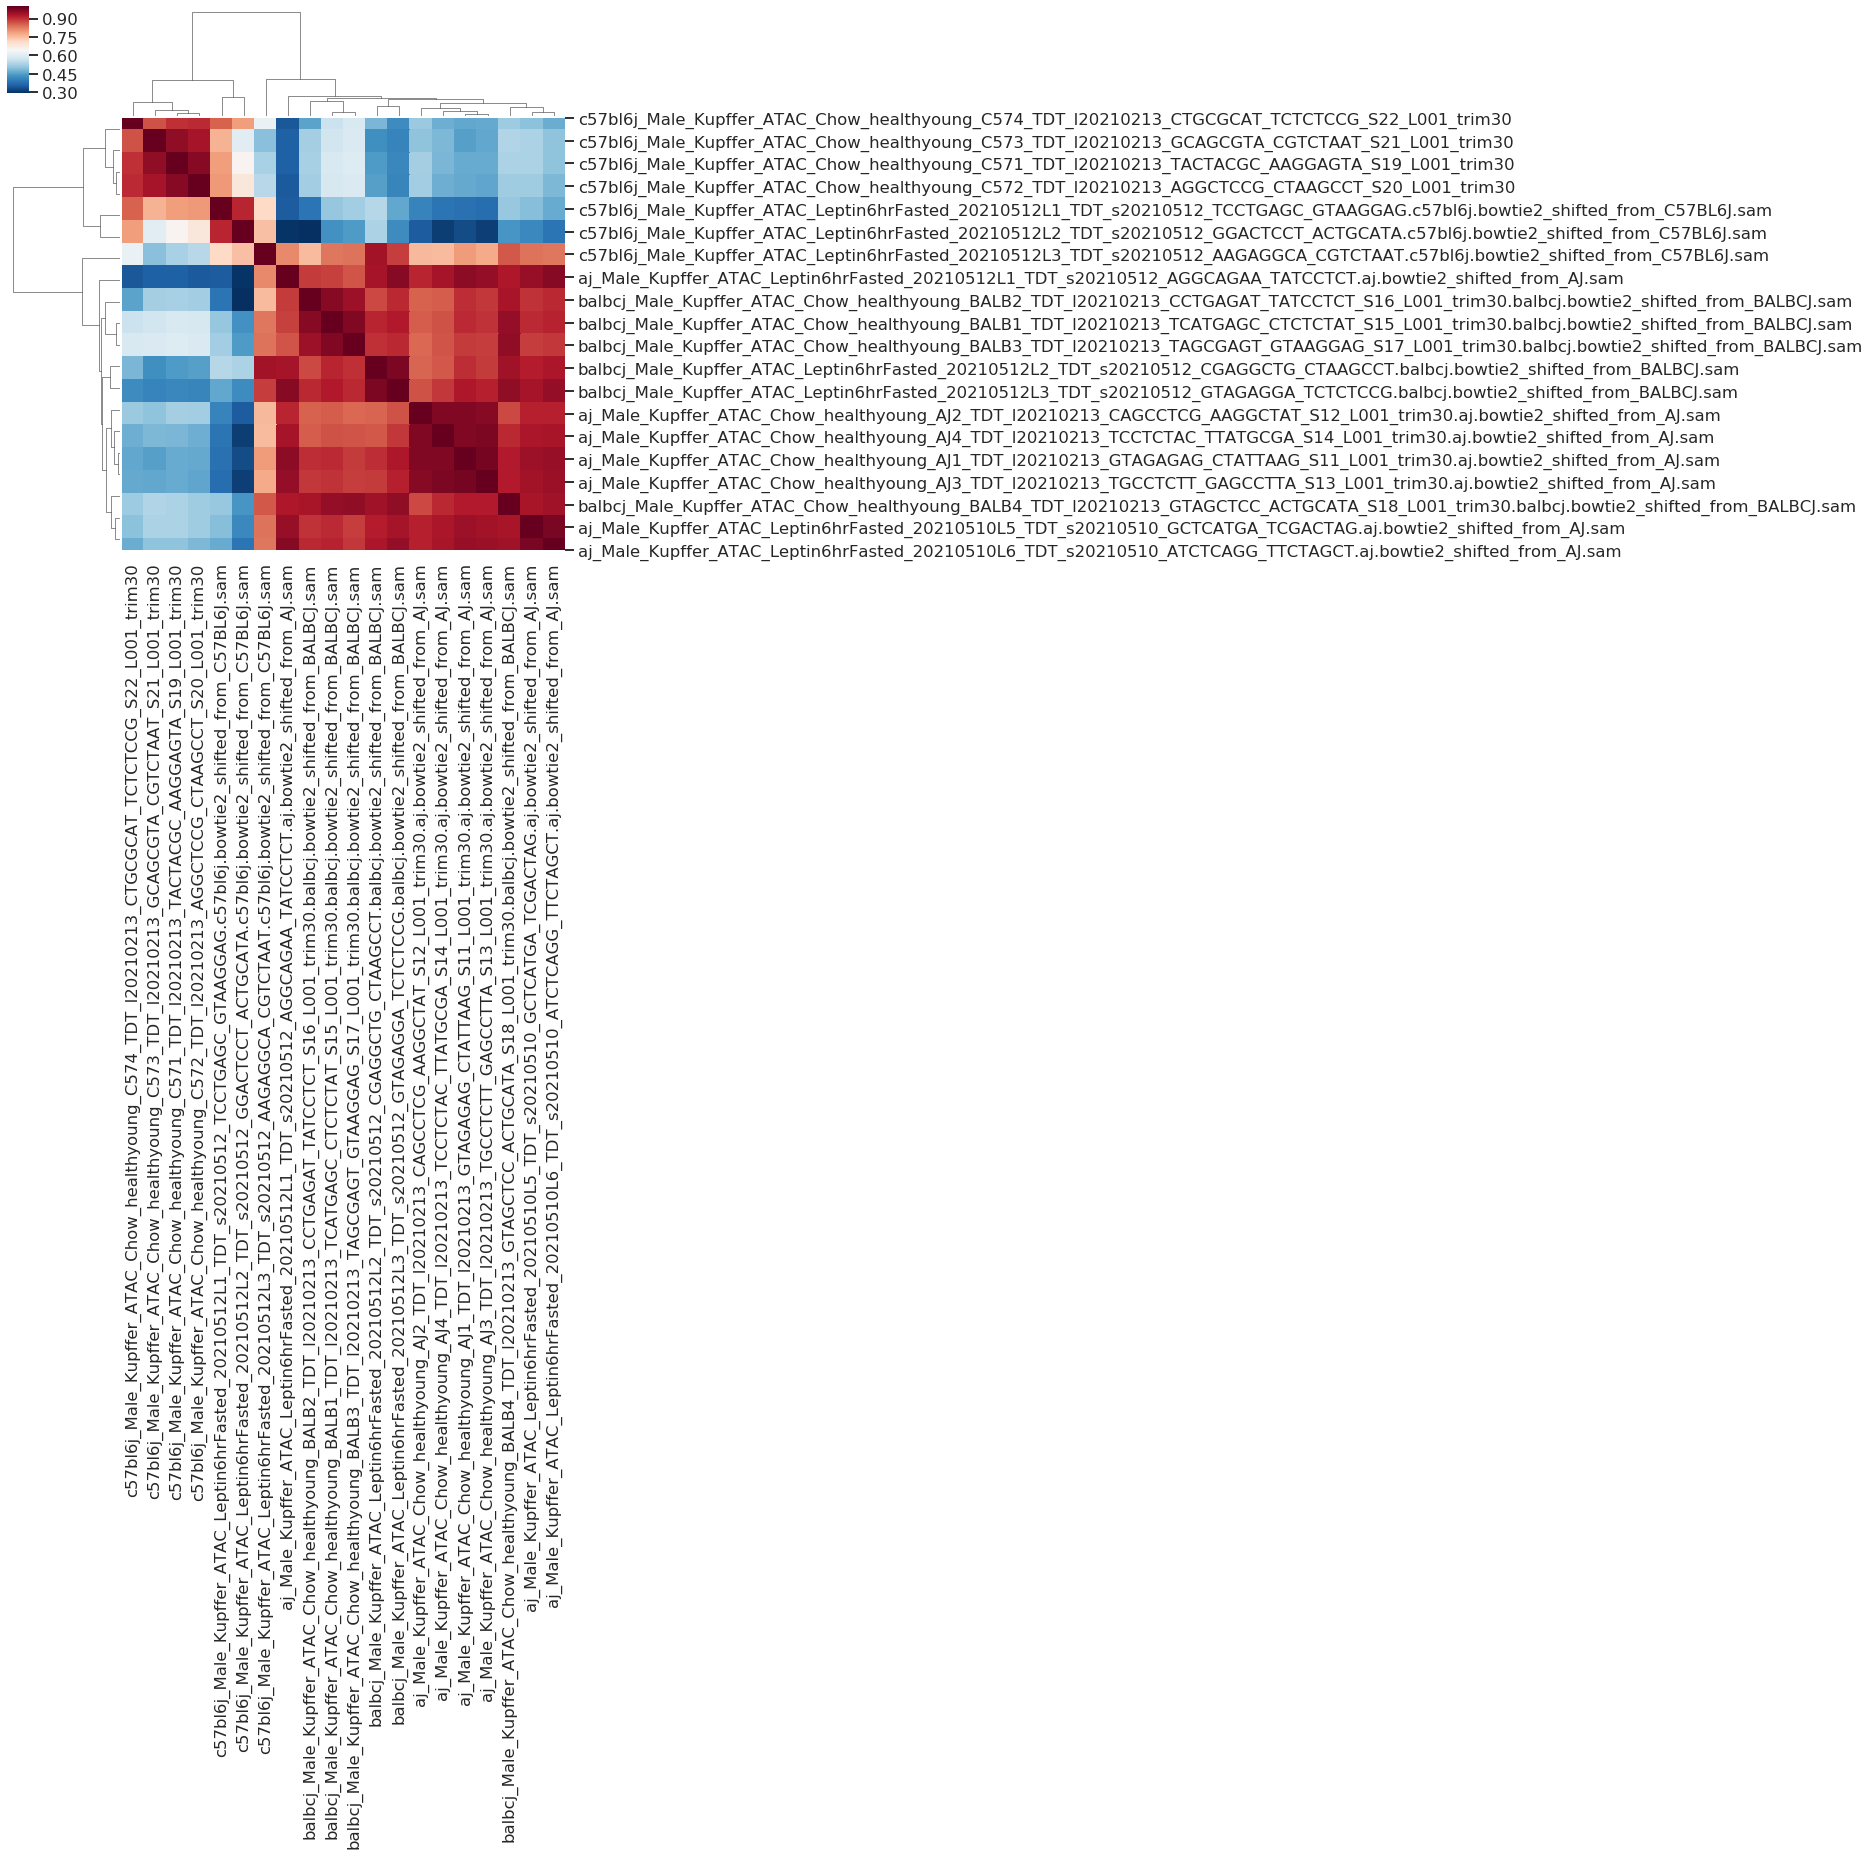

In [18]:
cm = sns.clustermap(mat_distal.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/atac_correlation_distal_heatmap.png', bbox_inches='tight')

# Principal Component Analysis

Create sample ID data frame for ease of plotting

In [21]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(mat.columns.str.split('/').str[-1])
group = samples.str.split('_').str[0]
strain = samples.str.split('_').str[0]
cell = samples.str.split('_').str[2]
treatment = samples.str.split('_').str[4]
treatment_time = samples.str.split('_').str[5]
mouseid = samples.str.split('_').str[8]
sampledate = samples.str.split('_').str[10]
                                        
samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(group),
                          pd.Series(strain),
                          pd.Series(cell),
                          pd.Series(treatment),
                          pd.Series(treatment_time),
                          pd.Series(mouseid),
                          pd.Series(sampledate)],
                         index=['mouse', 'group', 'strain', 'celltype',
                                'treatment', 'treatment_time', 'mouse_id',
                                'sample_date']).T

In [22]:
samplesDF

,mouse,group,strain,celltype,treatment,treatment_time,mouse_id,sample_date
0,c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C57...,c57bl6j,c57bl6j,Kupffer,Chow,healthyoung,l20210213,AAGGAGTA
1,c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C57...,c57bl6j,c57bl6j,Kupffer,Chow,healthyoung,l20210213,CTAAGCCT
2,c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C57...,c57bl6j,c57bl6j,Kupffer,Chow,healthyoung,l20210213,CGTCTAAT
3,c57bl6j_Male_Kupffer_ATAC_Chow_healthyoung_C57...,c57bl6j,c57bl6j,Kupffer,Chow,healthyoung,l20210213,TCTCTCCG
4,c57bl6j_Male_Kupffer_ATAC_Leptin6hrFasted_2021...,c57bl6j,c57bl6j,Kupffer,Leptin6hrFasted,20210512L1,TCCTGAGC,shifted
5,c57bl6j_Male_Kupffer_ATAC_Leptin6hrFasted_2021...,c57bl6j,c57bl6j,Kupffer,Leptin6hrFasted,20210512L2,GGACTCCT,shifted
6,c57bl6j_Male_Kupffer_ATAC_Leptin6hrFasted_2021...,c57bl6j,c57bl6j,Kupffer,Leptin6hrFasted,20210512L3,AAGAGGCA,shifted
7,balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB...,balbcj,balbcj,Kupffer,Chow,healthyoung,l20210213,CTCTCTAT
8,balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB...,balbcj,balbcj,Kupffer,Chow,healthyoung,l20210213,TATCCTCT
9,balbcj_Male_Kupffer_ATAC_Chow_healthyoung_BALB...,balbcj,balbcj,Kupffer,Chow,healthyoung,l20210213,GTAAGGAG


### Look at PCA plots for all the samples

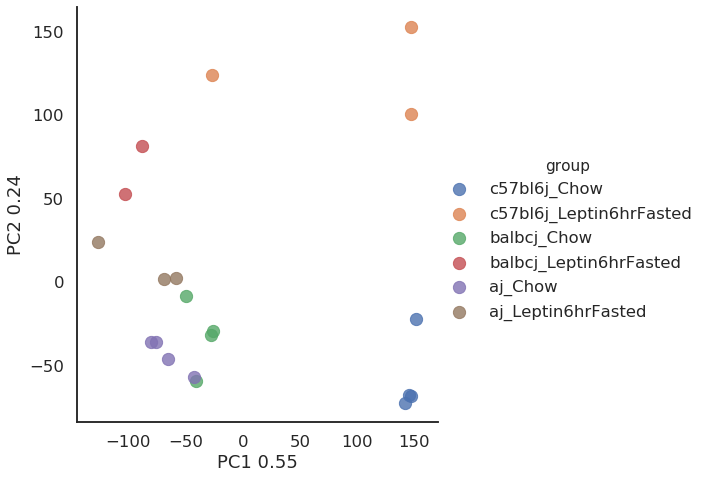

In [24]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=samplesDF.strain+'_'+samplesDF.treatment,
                                 plot_size=7,
                                 n_pca=3)

# label_point(pca.PC1,
#             pca.PC2,
#             samplesDF.mouse_id,
#             plt.gca())

plt.savefig('./figures/atac_pca1_pca2.png', bbox_inches='tight')

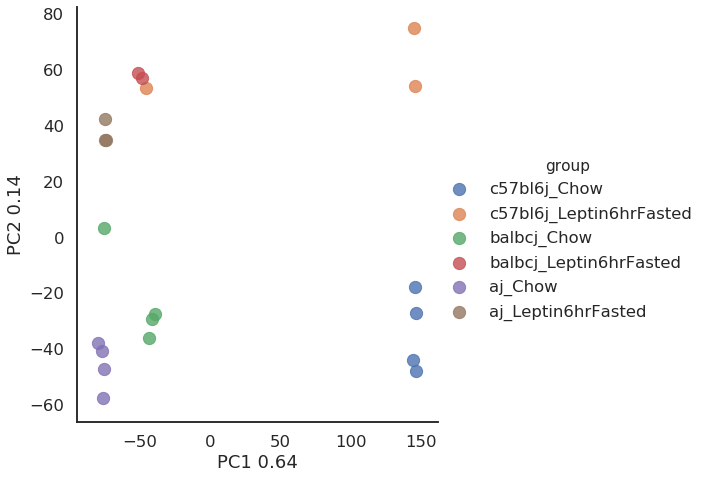

In [25]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
                                 group_labels=samplesDF.strain+'_'+samplesDF.treatment,
                                 plot_size=7,
                                 n_pca=3)
# label_point(pca.PC1,
#             pca.PC2,
#             samplesDF.mouse_id,
#             plt.gca())

plt.savefig('./figures/atac_pca1_pca2_quantnorm.png', bbox_inches='tight')

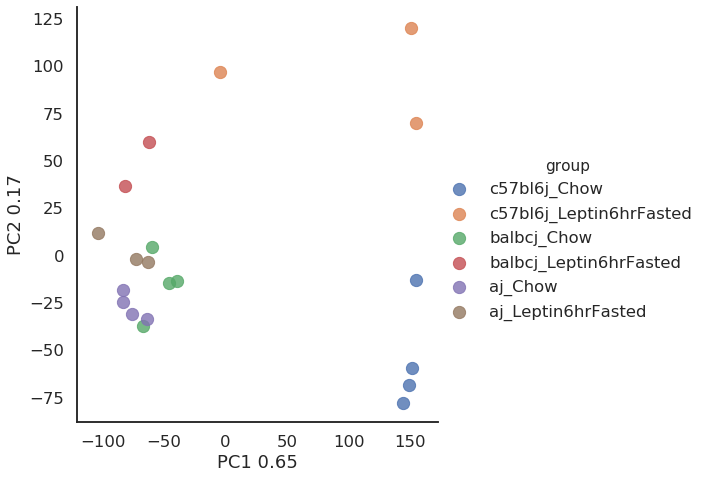

In [26]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_distal,
                                 group_labels=samplesDF.strain+'_'+samplesDF.treatment,
                                 plot_size=7,
                                 n_pca=3)

# label_point(pca.PC1,
#             pca.PC2,
#             samplesDF.mouse_id,
#             plt.gca())

plt.savefig('./figures/atac_distal_pca1_pca2.png', bbox_inches='tight')